# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

## Librerías de uso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from random import seed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score,cross_validate,ShuffleSplit,train_test_split
from sklearn.neural_network import MLPClassifier
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
seed(2) #Mantener el mismo set de aleatorios

## Procesamiento

### Lectura de los Datos

In [2]:
df = pd.read_csv('./datos/SMSSpamCollection.txt',sep="\t", header=None,encoding='latin-1')
df.columns=["Tipo", "Mensaje"]

In [3]:
df.head()

,Tipo,Mensaje
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Distribución de los Datos

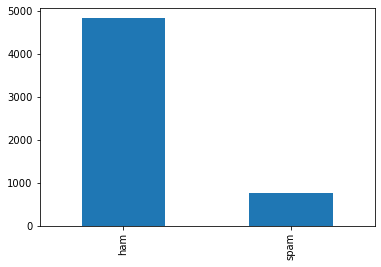

In [4]:
df.Tipo.value_counts().plot.bar();

Es necesario hacer un stemming de los datos, esto es una especie de traducción de cada palabra a su versión más atómica,
eliminando verbos y cerrando el conjunto de datos a uno más compacto, para después poder realizar el Bag of Words

In [5]:
stemmer = PorterStemmer()

df['stemmed'] = df.Mensaje.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,Tipo,Mensaje,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


### Bag of Words

Se realiza el bag of words contando las ocurrencias de cada palabra en la frase

In [6]:
count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5572, 1543)

In [7]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1543

In [8]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.Mensaje[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

## Regresión Logística

Se dividen los datos en conjuntos de testing y entrenamiento, posteriormente se realiza una regresión logística

In [9]:
X_train, X_test, y_train_true, y_test_true = train_test_split(dtm, df.Tipo, test_size=0.30, random_state=123)

In [10]:
clf = LogisticRegression(random_state=123, solver='lbfgs').fit(X_train, y_train_true)
forecast_y = clf.predict(X_test)

### Desempeño de la Regresión Logística

El objetivo de la clasificación es identificar el Spam para evitar que un envío de estos mensajes sea cobrado al usuario, para evaluar esta eficiencia se realiza una matriz de confusión, y se debe tener en cuenta que en especial se quieren reducir
los falsos positivos, es decir que no se marquen como Ham, los mensajes que deben ser Spam. Para evaluar el desempeño de la regresión logística se usarán la matriz de confusión, f1_score y la precisión (accuracy)

El porcentaje de Falsos Positivos es: 1.61%
El valor de F1 es: 0.9893360853113176
El porcentaje de precisión es del: 98.14593301435407%


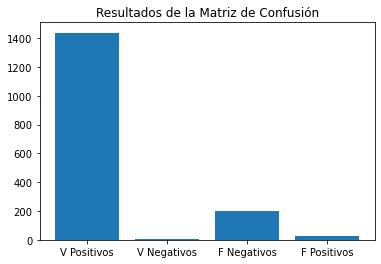

In [11]:
testresults_df = pd.DataFrame({"forecast_type":forecast_y,"real_type":y_test_true}, columns=["forecast_type","real_type"])
cm = confusion_matrix(y_test_true,forecast_y)
f1 = f1_score(y_test_true,forecast_y,pos_label="ham") #Valor verdadero es ham
acc = accuracy_score(y_test_true,forecast_y)*100
plt.title("Resultados de la Matriz de Confusión")
plt.bar(x=["V Positivos","V Negativos","F Negativos","F Positivos"], height=[cm[0][0],cm[0][1],cm[1][1],cm[1][0]])
false_p = round(100*cm[1][0]/len(y_test_true),2)
print("El porcentaje de Falsos Positivos es: {}%".format(false_p))
print("El valor de F1 es: {}".format(f1))
print("El porcentaje de precisión es del: {}%".format(acc))

También se grafican la distribución de los pronósticos y los valores reales

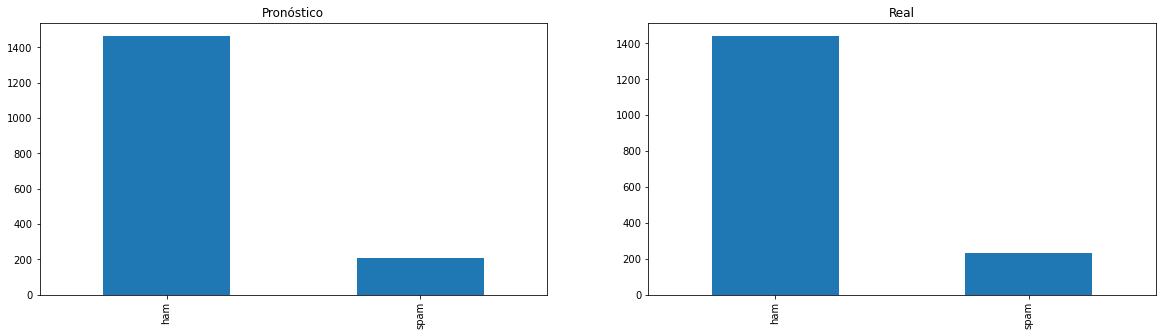

In [12]:
plt.figure(figsize=(20,5)) 
plt.subplot(1,2,1)
plt.title("Pronóstico")
testresults_df.forecast_type.value_counts().plot.bar();
plt.subplot(1,2,2)
plt.title("Real")
testresults_df.real_type.value_counts().plot.bar();

### Resultados de la Regresión Logística

El desempeño de la regresión logística se considera bueno ya que se comporta bien respecto a las medidas de desempeño elegidas, presentando en todas valores buenos, cabe aclarar que en la métrica f1 entre más cercano se encuentre a 1, mejor.

## Modelo con Redes Neuronales

Inicialmente se desarrolla un modelo con redes neuronales base (5,5), para evaluar su desempeño inicial.

In [13]:
model = MLPClassifier(
            hidden_layer_sizes=(5,5),
            activation='logistic',
            solver='sgd',
            learning_rate='adaptive',
            learning_rate_init=0.05,
            random_state=123,
            max_iter=1000
        )

model.fit(X_train,y_train_true)
forecast_y = model.predict(X_test)

El porcentaje de Falsos Positivos es: 1.14%
El valor de F1 es: 0.990324809951624
El porcentaje de precisión es del: 98.32535885167464%


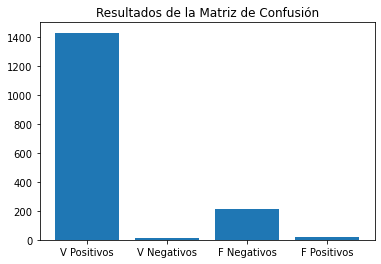

In [14]:
cm = confusion_matrix(y_test_true,forecast_y)
f1 = f1_score(y_test_true,forecast_y,pos_label="ham") #d
acc = accuracy_score(y_test_true,forecast_y)*100
plt.title("Resultados de la Matriz de Confusión")
plt.bar(x=["V Positivos","V Negativos","F Negativos","F Positivos"], height=[cm[0][0],cm[0][1],cm[1][1],cm[1][0]])
false_p = round(100*cm[1][0]/len(y_test_true),2)
print("El porcentaje de Falsos Positivos es: {}%".format(false_p))
print("El valor de F1 es: {}".format(f1))
print("El porcentaje de precisión es del: {}%".format(acc))

### Selección del Modelo

Según el modelo inicial, podemos observar que los resultados brindados por el modelo de redes neuronales son bastante parecidos a la regresión logística.

Para la selección del modelo se realizará crossvalidation con las métricas de desempeño usadas anteriormente, variando la cantidad de neuronas de 1 a 6

In [ ]:
max_layer_size = 7
cv_split = ShuffleSplit(test_size=0.30, random_state=123) # Configuracion crossvalidation 
benchmark_df = pd.DataFrame(columns=["N_l1", "N_l2", "F1", "Precisión"])
for neurons_l1 in range(1,max_layer_size):
    for neurons_l2 in range(2,max_layer_size):
        model = MLPClassifier(
            hidden_layer_sizes=(neurons_l1,neurons_l2),
            activation='logistic',
            solver='sgd',
            learning_rate='adaptive',
            learning_rate_init=0.05,
            random_state=123,
            max_iter=1000
        )
        
        f1 = make_scorer(f1_score,pos_label='ham')
        acc = make_scorer(accuracy_score)
        score = cross_validate(model, dtm, df.Tipo, cv=cv_split, scoring={"f1":f1,"acc":acc})
        entry = {"N_l1":neurons_l1,"N_l2":neurons_l2,"F1":score['test_f1'].mean(),"Precisión":score['test_acc'].mean()}
        benchmark_df = benchmark_df.append(entry, ignore_index=True)
        
benchmark_df.head()        

In [ ]:
best_f1 = benchmark_df[benchmark_df.F1 == benchmark_df.F1.max()]
best_acc = benchmark_df[benchmark_df['Precisión'] == benchmark_df['Precisión'].max()]
best_f1.head()

### Modelo Seleccionado
Basándose en las métricas de desempeño, se seleccionó el modelo con 6 y 3 neuronas en la capa de entrada y oculta respectivamente. Notar que el valor de F1 no mejoró bastante respecto a los modelos anteriores

In [ ]:
##Graficar el crecimiento y decrecimiento del error
plt.figure(figsize=(20,30)) 
x_vals = list(range(2, max_layer_size))
for i in range(max_layer_size-1):
    plt.subplot(max_layer_size,1,i+1)   
    plt.xlabel('Neuronas en la Capa Oculta')
    plt.ylabel('Valor')
    plt.title('#Neuronas: '+str(i+1))
    aux_df = benchmark_df[benchmark_df.N_l1 == i+1]
    plt.plot(x_vals,aux_df['F1'], label='F1', color='blue')
    plt.plot(x_vals,aux_df['Precisión'], label="Precisión", color='red')
    plt.tight_layout(h_pad=3.0)
    
    plt.legend()

    

## Modelo de Clasificación por Redes Neuronales


In [ ]:
n1 = best_f1['N_l1'].values[0]
n2 = best_f1['N_l2'].values[0]
X_train, X_test, y_train_true, y_test_true = train_test_split(dtm, df.Tipo, test_size=0.30, random_state=123)

model = MLPClassifier(
            hidden_layer_sizes=(int(n1),int(n2)),
            activation='logistic',
            solver='sgd',
            learning_rate='adaptive',
            learning_rate_init=0.05,
            random_state=123,
            max_iter=1000
        )

model.fit(X_train,y_train_true)
forecast_y = model.predict(X_test)

testresults_df = pd.DataFrame({"forecast_type":forecast_y,"real_type":y_test_true}, columns=["forecast_type","real_type"])
cm = confusion_matrix(y_test_true,forecast_y)
f1 = f1_score(y_test_true,forecast_y,pos_label="ham") #Valor verdadero es ham
acc = accuracy_score(y_test_true,forecast_y)*100
plt.title("Resultados de la Matriz de Confusión")
plt.bar(x=["V Positivos","V Negativos","F Negativos","F Positivos"], height=[cm[0][0],cm[0][1],cm[1][1],cm[1][0]])
false_p = round(100*ecm[1][0]/len(y_test_true),2)
print("El porcentaje de Falsos Positivos es: {}%".format(false_p))
print("El valor de F1 es: {}".format(f1))
print("El porcentaje de precisión es del: {}%".format(acc))


## Conclusión

Todos los modelos encontrados tienen resultados bastante similares en las medidas de desempeño, y en general todos brindan muy buenos resultados, todos manteniendo un porcentaje de falsos positivos menor al 2% y un valor de f1 bastante cercano a 1, todos mayor a 0.9